In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


2024-01-03 02:24:56.415889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 02:24:56.415963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 02:24:56.443605: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 02:24:56.558862: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-03 02:24:57.654099: W tensorflow/compiler/tf2

TensorFlow version: 2.15.0


In [4]:
from Bio import SeqIO
from tensorflow import keras as kr
import numpy as np


import glob
from nombreCarpetas import ver_carpetas
import pandas as pd
import os
import psutil
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [5]:
#def buscar_archivos(path):

def buscar_archivos(path):
    
    fastq_files = glob.glob(f'{path}/*.fastq',recursive=True)  # This pattern assumes the files are in subdirectories, adjust it as needed

    return fastq_files

In [6]:
#def buscar_archivos_fastq(path):
def buscar_archivos_fastq(path):
    
    fastq_files = glob.glob(f'{path}/*.fastq',recursive=True)  # This pattern assumes the files are in subdirectories, adjust it as needed

    return fastq_files

In [7]:
#def buscar_archivos_fasta(path):
def buscar_archivos_fasta(path):
    
    fastq_files = glob.glob(f'{path}/*.trim.contigs.good.fasta',recursive=True)  # This pattern assumes the files are in subdirectories, adjust it as needed

    return fastq_files

In [8]:
#buscar carpetas y contenidos
vc= ver_carpetas()
folders_path="../tutorialM/datos/sets3"
#folders_path="test"

nombres=vc.ver_carpetas(folders_path)
print(f"numero carpetas:{len(nombres)}")
paths=[]
for nombre in nombres:
    paths.append(folders_path+"/"+nombre)
print(f"ejemplo {paths[0]}")
print(buscar_archivos(paths[0]))
print(f"largo de paths: {len(paths)}")


Folders inside the directory
numero carpetas:301
ejemplo ../tutorialM/datos/sets3/Folder_1
['../tutorialM/datos/sets3/Folder_1/F4D148_S244_L001_R2_001.fastq', '../tutorialM/datos/sets3/Folder_1/F4D148_S244_L001_R1_001.fastq']
largo de paths: 301


In [13]:
#process_paired_fastq_files
from Bio import SeqIO

def process_paired_fastq_files(file1, file2,ids):
    sequences_r1 = [[] for _ in range(len(ids))]
    sequences_r2 = [[] for _ in range(len(ids))]
    qualities_f = [[] for _ in range(len(ids))]
    qualities_r= [[] for _ in range(len(ids))]
    aux=[]

    with open(file1, "r") as handle1, open(file2, "r") as handle2:
        for record1, record2 in zip(SeqIO.parse(handle1, "fastq"), SeqIO.parse(handle2, "fastq")):
            assert record1.id.split()[0] == record2.id.split()[0], "Mismatch in paired reads"
            R1_id_mod= record1.id.split()[0].replace(":", "_")
            # Append sequences from both files separately
            seq1 = str(record1.seq)
            seq2 = str(record2.seq)

        
            len_diff1 = len(seq1) - len(record1.letter_annotations["phred_quality"])
            if len_diff1 > 0:
                record1.letter_annotations["phred_quality"].extend([0] * len_diff1)
            len_diff2 = len(seq2) - len(record2.letter_annotations["phred_quality"])
            if len_diff2 > 0:
                record2.letter_annotations["phred_quality"].extend([0] * len_diff2)
            
            
            # Append quality scores for both records separately as lists
            for i, id in enumerate(ids):
                if(id==R1_id_mod):
                    sequences_r1[i]=(seq1)
                    sequences_r2[i]=(seq2)
                    qualities_f[i]=(record1.letter_annotations["phred_quality"])
                    qualities_r[i]=(record2.letter_annotations["phred_quality"])
                    aux.append(R1_id_mod)
    print(len(aux))
    print(len(ids))

      
    return np.array(sequences_r1),np.array(sequences_r2),qualities_f,qualities_r


In [14]:
#leer doble fasta
def recorrer_fa_primero(file1):
    seqs_fa = []

    id1=[]

    for record3 in SeqIO.parse(file1, "fasta"):
            
        seqs_fa.append(str(record3.seq))
        id1.append(record3.id.split()[0])


    return np.array(seqs_fa),id1

In [16]:
#process_fasta_file

import numpy as np
from Bio import SeqIO

def process_fasta_file(file,ids_seqs):
    sequences = []
    ids_tgt=[]
    with open(file, "r") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            sequences.append(str(record.seq))
            ids_tgt.append(record.id.split()[0])
    
    max_len = max(len(ids_tgt), len(ids_seqs))
    for i in range(max_len):
        if ids_seqs[i] != ids_tgt[i]:
            ids_tgt.insert(i,ids_seqs[i])
            sequences.insert(i,"N"*300)

    return np.array(sequences), ids_tgt


In [17]:
#hot encode con calidad
def encode_sequence_with_quality(sequence, quality_scores):
    mapping = {
        'A': [1, 0, 0, 0, 0],
        'C': [0, 1, 0, 0, 0],
        'G': [0, 0, 1, 0, 0],
        'T': [0, 0, 0, 1, 0],
        'N': [0, 0, 0, 0, 1]
    }

    default_value = mapping['N']

    encoded_sequence = []
    norm_quality = []

    for i, base in enumerate(sequence):
        base_encoding = mapping.get(base, default_value)

        if quality_scores[i]:
            quality = quality_scores[i]
        else:
            quality = 0

        normalized_quality = (
            1.0 if quality >= 50 else (quality - 30) / 20 if quality > 30 else 0.0
        )

        encoded_sequence.append(base_encoding)
        norm_quality.append(normalized_quality)

    return np.array(encoded_sequence), np.array(norm_quality)


def encode_fastq(sequences,quality,max_sequence_length=253):
    encoded_sequences = []
    normal_qualities=[]
    for qual,seq in zip(quality,sequences):
        if len(seq) < max_sequence_length:
            seq += 'N' * (max_sequence_length - len(seq))
            qual.extend([0] * len(seq))# Pad sequence with 'N' to reach max length
        encoded_seq,norm_qual = encode_sequence_with_quality(seq[:max_sequence_length],qual)  # Truncate or pad to fixed length
        encoded_sequences.append(encoded_seq)
        normal_qualities.append(norm_qual)
    return np.array(encoded_sequences),np.array(normal_qualities)

In [18]:
def normalize_quality(scores):
    normalized = []
    for score in scores:
        if score >= 50:
            normalized.append(1.0)  # Mejor calidad
        elif score <= 30:
            normalized.append(0.0)  # Baja calidad
        else:
            normalized.append((score - 30) / 20)  # Normalización lineal entre 30 y 50
    return np.array(normalized)

In [19]:
def one_hot_encode_sequence(sequence):
    mapping = {
        'A': [1, 0, 0, 0, 0],
        'C': [0, 1, 0, 0, 0],
        'G': [0, 0, 1, 0, 0],
        'T': [0, 0, 0, 1, 0],
        'N': [0, 0, 0, 0, 1]
    }

    default_value = mapping['N']
    return [mapping.get(base, default_value) for base in sequence]


def encode_fasta(sequences, max_sequence_length=253):
    encoded_sequences = []
    for seq in sequences:
        if len(seq) < max_sequence_length:
            seq += 'N' * (max_sequence_length - len(seq))  # Pad sequence with 'N' to reach max length
        encoded_seq = one_hot_encode_sequence(seq[:max_sequence_length])
        encoded_sequences.append(encoded_seq)
    return np.array(encoded_sequences)

In [24]:
def train_model(model,input_1,input_2,input_3,input_4, targets, batch_size=32,epochs=2):

    return model.fit(
        x=[input_1, input_2,input_3,input_4],
        y=targets,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        shuffle=True
    )

In [20]:
batch_size=15
print(len(paths))
for i in range(0, len(paths), batch_size):
    batch_paths = paths[i:i+batch_size]  # Get a batch of paths
    # Process each folder in the batch
    for j, path in enumerate(batch_paths):
        #combined=[]
        print("cargando archivos, it:",i+j+1)
        paired_files = buscar_archivos_fastq(path)
        fasta_files= buscar_archivos_fasta(path)
        
        items_tgt=recorrer_fa_primero(fasta_files[0])
        
        items_seqs= process_paired_fastq_files(paired_files[0], paired_files[1],items_tgt[1])
  
        
        #print(items_seqs[0])
        #print(items_tgt[0])
        encoded_fr,qual_fr=encode_fastq(items_seqs[0],items_seqs[2])
        encoded_rv,qual_rv=encode_fastq(items_seqs[1],items_seqs[3])
        encoded_tg=encode_fasta(items_tgt[0])
        
    
        #a=np.stack([encoded_fr,encoded_rv],axis=1)
        #print(encoded_tg)
        #print(a.shape)
        #print(encoded_fr.shape)
        #print(encoded_rv.shape)
        #print(encoded_tg.shape)
        """
        historia=model.fit(
            x=[encoded_fr,
            encoded_rv,
            qual_fr,
            qual_rv],
            y=encoded_tg,
            batch_size=300,
            epochs=100,
            validation_split=0.2
        )
        """
        
        np.save(f'seqs4/qual_fr_{i+j+1}.npy', np.array(qual_fr))
        np.save(f'seqs4/qual_rv_{i+j+1}.npy', np.array(qual_rv))

        np.save(f'seqs4/encoded_fr_{i+j+1}.npy', np.array(encoded_fr))
        np.save(f'seqs4/encoded_rv_{i+j+1}.npy', np.array(encoded_rv))
        np.save(f'seqs4/encoded_tg_{i+j+1}.npy', np.array(encoded_tg))
        #print(f"Saving files N:{i+j+1}")


301
cargando archivos, it: 1
15749
15749
cargando archivos, it: 2
15749
15749
cargando archivos, it: 3
6693
6693
cargando archivos, it: 4
10454
10454
cargando archivos, it: 5
11076
11076
cargando archivos, it: 6
14527
14527
cargando archivos, it: 7
6416
6416
cargando archivos, it: 8
17481
17481
cargando archivos, it: 9
6420
6420
cargando archivos, it: 10
8635
8635
cargando archivos, it: 11
3877
3877
cargando archivos, it: 12
5186
5186
cargando archivos, it: 13
10611
10611
cargando archivos, it: 14
19753
19753
cargando archivos, it: 15
7882
7882
cargando archivos, it: 16
2367
2367
cargando archivos, it: 17
7822
7822
cargando archivos, it: 18
4951
4951
cargando archivos, it: 19
6640
6640
cargando archivos, it: 20
3104
3104
cargando archivos, it: 21
2879
2879
cargando archivos, it: 22
7636
7636
cargando archivos, it: 23
11921
11921
cargando archivos, it: 24
9142
9142
cargando archivos, it: 25
4397
4397
cargando archivos, it: 26
11878
11878
cargando archivos, it: 27
3131
3131
cargando arch

OSError: Not enough free space to write 144594560 bytes

In [28]:
import tensorflow as tf
from tensorflow.keras.losses import Huber

def model_cnn_lstm_with_dropout():
    input_1 = tf.keras.Input(shape=(253, 4))
    input_2 = tf.keras.Input(shape=(253, 4))
    input_3 = tf.keras.Input(shape=(253, 1))
    input_4 = tf.keras.Input(shape=(253, 1))

    # Convoluciones iniciales para inputs 1 y 2
    x1 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_1)
    x1 = tf.keras.layers.MaxPooling1D(2)(x1)

    x2 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_2)
    x2 = tf.keras.layers.MaxPooling1D(2)(x2)

    # Convoluciones iniciales para inputs 3 y 4
    x3 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_3)
    x3 = tf.keras.layers.MaxPooling1D(2)(x3)

    x4 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_4)
    x4 = tf.keras.layers.MaxPooling1D(2)(x4)

    # Concatenar los resultados de todas las entradas
    x = tf.keras.layers.Concatenate(axis=2)([x1, x2, x3, x4])

    # Capa adicional convolucional para ajustar dimensiones antes de la LSTM
    x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)

    # Capa LSTM
    x = tf.keras.layers.LSTM(64, return_sequences=True)(x)

    # Reducción de dimensiones con capas Dense adicionales y Dropout
    # Capas adicionales con diferentes funciones de activación
    x = tf.keras.layers.Dense(16, activation='softmax')(x)
    x = tf.keras.layers.Dense(8, activation='tanh')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)

    # Salida final con la forma deseada (None, 253, 4)
    outputs = tf.keras.layers.Dense(253 * 4, activation='sigmoid')(x)
    outputs = tf.keras.layers.Reshape((253, 4))(outputs)

    optimizer = tf.keras.optimizers.Adam()
    #loss = Huber(delta=0.5, reduction="auto", name="huber_loss")
    loss=tf.keras.losses.MeanSquaredError()

    model = tf.keras.Model(inputs=[input_1, input_2, input_3, input_4], outputs=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', 'mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    return model

# Llama a la función para crear el modelo con las 4 entradas
model = model_cnn_lstm_with_dropout()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 253, 4)]             0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 253, 4)]             0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 253, 1)]             0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 253, 1)]             0         []                            
                                                                                            

In [125]:
#modelo custom, 2 inputs, 1 salida
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense,Reshape,Conv1D , MaxPooling1D,Concatenate

def create_custom_sequential_model():
    # Define inputs
    input_1 = kr.Input(shape=(5, 1),name="input_1")
    input_2 = kr.Input(shape=(5, 1),name="input_2")

    # Flatten inputs
    flat_1 = Flatten()(input_1)
    flat_2 = Flatten()(input_2)

    # Concatenate flattened inputs
    merged = Concatenate()([flat_1, flat_2])

    # Dense layers
    dense_1 = Dense(64, activation='relu')(merged)
    dense_2 = Dense(32, activation='relu')(dense_1)
    dense_2 = Dense(64, activation='relu')(dense_2)
    dense_2 = Dense(32, activation='sigmoid')(dense_2)
    dense_2 = Dense(32, activation='relu')(dense_2)

    # Output layer
    output = Dense(1, activation='softmax')(dense_2)

    # Create model
    model = kr.Model(inputs=[input_1, input_2], outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Adjust loss and metrics as needed
    model.summary()
    return model

In [126]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Reshape
from keras.optimizers import AdamW,Adamax,Adagrad,Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.losses import Huber, MeanSquaredError
import tensorflow as tf

def modelo_personalizado():
    input_1 = tf.keras.Input(shape=(253, 5))
    input_2 = tf.keras.Input(shape=(253, 5))
    
    x1 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_1)
    x1 = tf.keras.layers.MaxPooling1D(2)(x1)
    
    x2 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(input_2)
    x2 = tf.keras.layers.MaxPooling1D(2)(x2)
    
    combined = tf.keras.layers.concatenate([x1, x2])
    
    combined = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(combined)
    combined = tf.keras.layers.MaxPooling1D(2)(combined)
    combined = tf.keras.layers.Dropout(0.3)(combined)
    combined = tf.keras.layers.Flatten()(combined)
    
    outputs = tf.keras.layers.Dense(1008, activation='sigmoid')(combined)
    outputs = tf.keras.layers.Dense(253 * 4, activation='relu')(outputs)
    outputs = tf.keras.layers.Reshape((253, 4))(outputs)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(outputs)

    lr_schedule = ExponentialDecay(initial_learning_rate=0.1, decay_steps=10000, decay_rate=0.9)
    optimizer = Adam(learning_rate=lr_schedule)
    loss = MeanSquaredError(reduction="auto", name="huber_loss")
    
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', 'mse', 'mae'])
    model.summary()
    return model






In [127]:
#def train_model
def train_model(model,input_1,input_2, targets, batch_size=32,epochs=2):

    return model.fit(
        x=[input_1, input_2],
        y=targets,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        shuffle=True
    )

In [128]:
#def train_model 2
def train_model2(model,input, targets, batch_size=50,epochs=2):

    return model.fit(
        x=input,
        y=targets,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2
    )

In [129]:
#asignar modelo
model = modelo_personalizado()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 253, 5)]             0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 253, 5)]             0         []                            
                                                                                                  
 conv1d_17 (Conv1D)          (None, 253, 32)              512       ['input_11[0][0]']            
                                                                                                  
 conv1d_18 (Conv1D)          (None, 253, 32)              512       ['input_12[0][0]']            
                                                                                            

In [130]:
# Inicializa  parametros del modelos
initial_epoch = 0  
epoch=10
aux = len(paths)
history_model=[]
batch_size = 10  

In [131]:


history = train_model(
        model,
        encoded_fr,
        encoded_rv,
        encoded_tg,
        
        epochs=300
        #initial_epoch=initial_epoch
    )

ValueError: Data cardinality is ambiguous:
  x sizes: 1420, 1420
  y sizes: 0
Make sure all arrays contain the same number of samples.

In [ ]:
data_1= encoded_rv.reshape(-1, 253, 5, 1)
data_2= encoded_fr.reshape(-1, 253, 5, 1)
data_3= encoded_tg.reshape(-1, 253, 4, 1)

In [ ]:
print(encoded_fr.shape)
print(encoded_rv.shape)
print(encoded_tg.shape)

(5517, 253, 5)
(5517, 253, 5)
(5517, 253, 4)


In [ ]:

# Aplanar los datos de entrada 1
X_input1_flat = data_1.reshape(data_1.shape[0], -1)  # Cambiar la forma a (None, 1265)

# Aplanar los datos de entrada 2
X_input2_flat = data_2.reshape(data_2.shape[0], -1)  # Cambiar la forma a (None, 1012)

# Aplanar los datos de salida
y_output_flat = data_3.reshape(data_3.shape[0], -1)  # Cambiar la forma a (None, 1012)

print(X_input1_flat.shape)
print(X_input2_flat.shape)
print(y_output_flat.shape)


(5517, 1265)
(5517, 1265)
(5517, 1012)


In [ ]:
X_seq1_flat = np.reshape(encoded_fr, (encoded_fr.shape[0], -1))  # Aplanar X_seq1
X_seq2_flat = np.reshape(encoded_rv, (encoded_rv.shape[0], -1))  # Aplanar X_seq2

# Concatenar los datos aplanados
X_combined_flat = np.concatenate((X_seq1_flat, X_seq2_flat), axis=1)
print(X_combined_flat.shape)

(5517, 2530)


In [ ]:
y_train = np.reshape(encoded_tg, (encoded_tg.shape[0], -1))  # Aplanar X_seq2
print(y_train.shape)

(5517, 1012)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Dividir los datos en conjuntos de entrenamiento y prueba
#X_train1, X_test1, X_train2, X_test2, y_train, y_test = train_test_split(X_input1_flat, X_input2_flat, y_output_flat, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_combined_flat, y_train, test_size=0.2, random_state=42)

# Inicializar el regresor RandomForest
rf_regressor = RandomForestRegressor(n_estimators=150, random_state=42)

# Entrenar el modelo
rf_regressor.fit(X_train, y_train)
#rf_regressor.fit([X_train1, X_train2], y_train)

# Predecir en el conjunto de prueba
y_pred = rf_regressor.predict(X_test)
#predictions = rf_regressor.predict([X_test1, X_test2])

# Calcular el error (si es necesario)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.04038272123407993


In [ ]:
print(y_pred.shape)
matriz_reshaped = np.reshape(y_pred, (-1, 253, 4))
print(matriz_reshaped.shape)


(1104, 1012)
(1104, 253, 4)


In [ ]:

def adjust_max_probabilities(encoded_sequence):

    adjusted_sequence = np.copy(encoded_sequence)
    for seq in adjusted_sequence:
        max_values = np.max(seq, axis=1, keepdims=True)
        max_indices = np.where(seq == max_values, 1, 0)
        num_max_values = np.sum(max_indices, axis=1, keepdims=True)
        num_max_values_float = (1 / num_max_values).astype(float)  # Convertir a float
        max_indices *= num_max_values_float
        seq *= (1 - max_indices)
        seq += max_indices
    return adjusted_sequence


# Ejemplo de uso:

adjusted_sequence = adjust_max_probabilities(matriz_reshaped)
print(adjusted_sequence)


UFuncTypeError: Cannot cast ufunc 'multiply' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [ ]:
from joblib import dump, load
dump(rf_regressor, 'modelo_bosque_de_regresion.joblib')

['modelo_bosque_de_regresion.joblib']

In [ ]:
modelo_cargado = load('modelo_arbol_de_regresion.joblib')

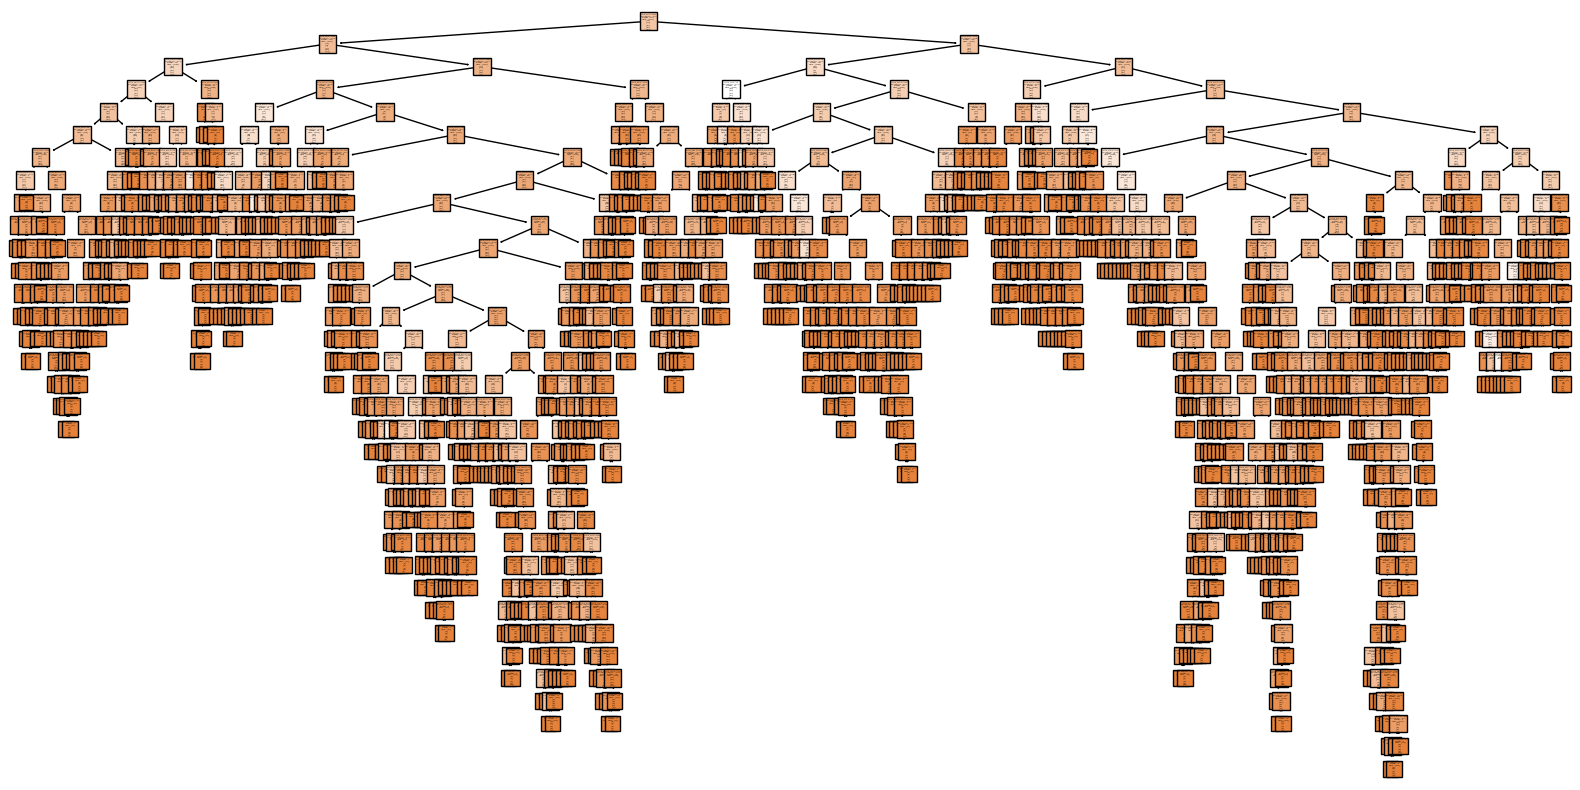

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

tree = rf_regressor.estimators_[0]  # Puedes cambiar el índice para visualizar otro árbol

# Grafica el árbol
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=[f'feature_{i}' for i in range(X_combined_flat.shape[1])], class_names=['0', '1'])
plt.show()